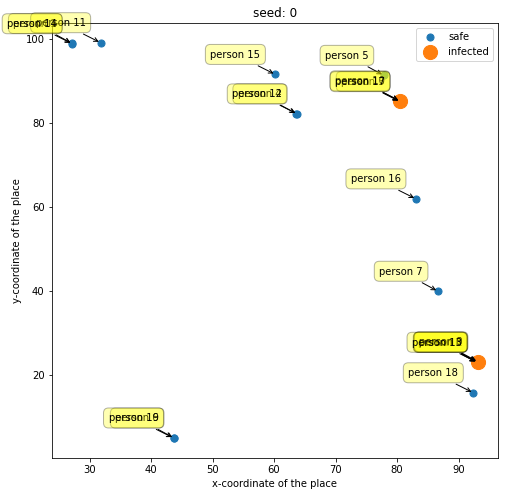

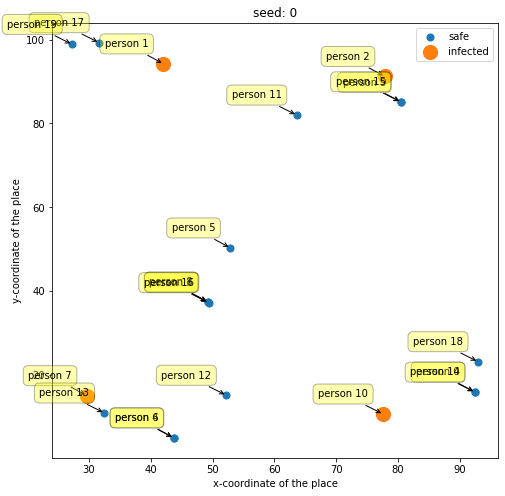

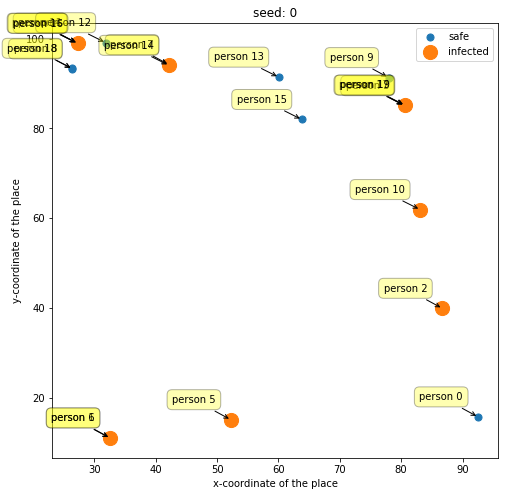

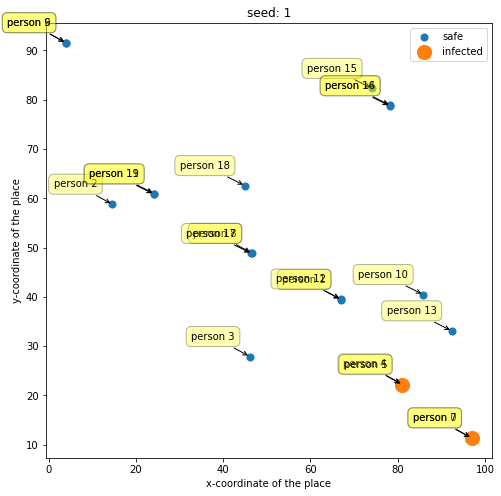

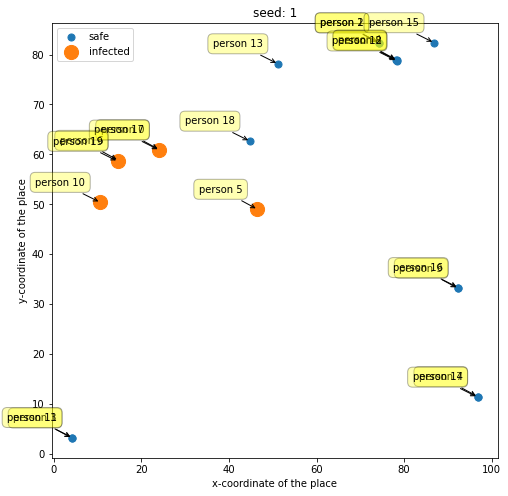

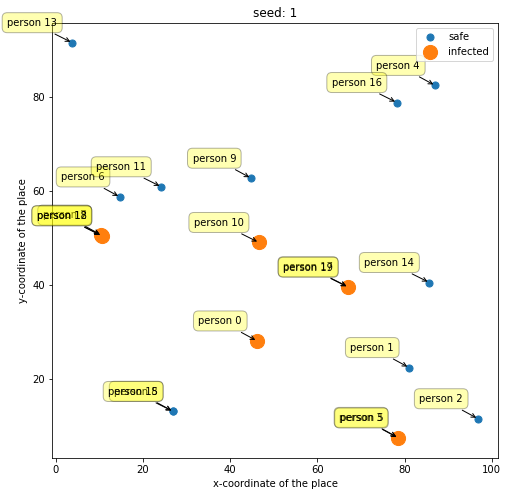

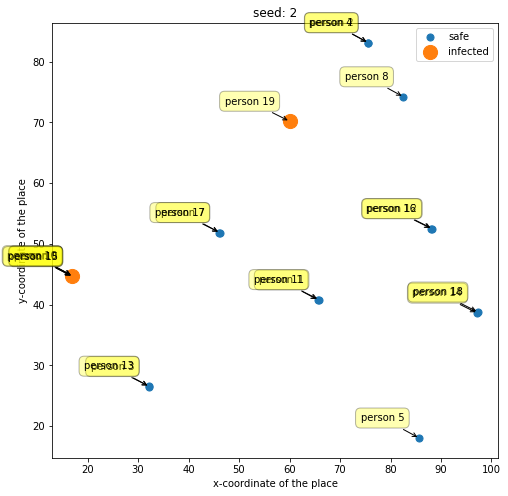

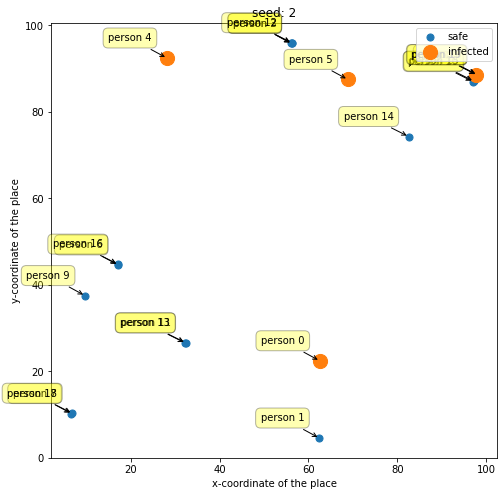

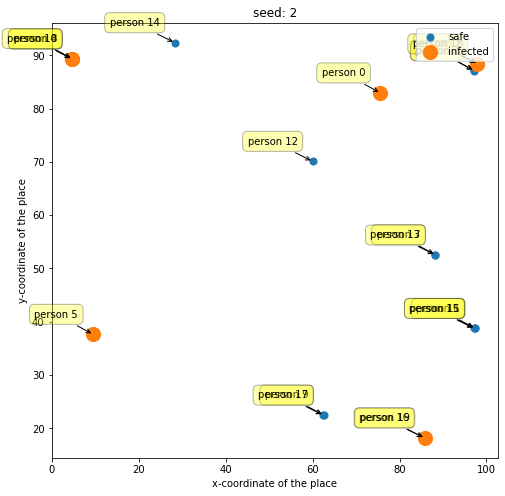

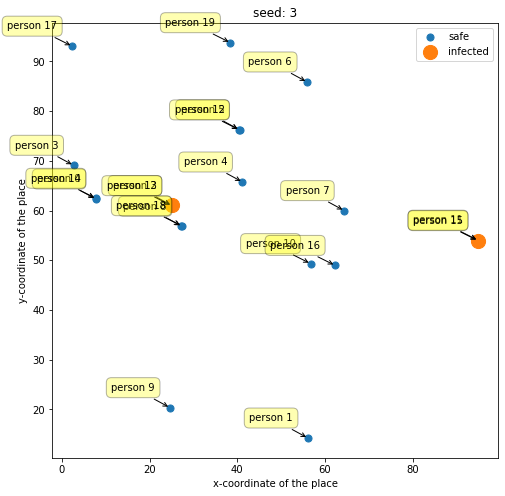

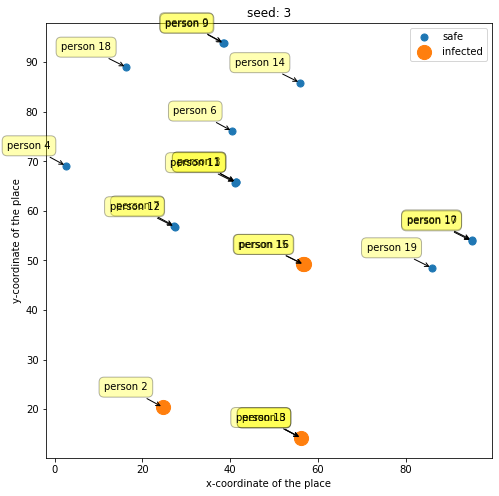

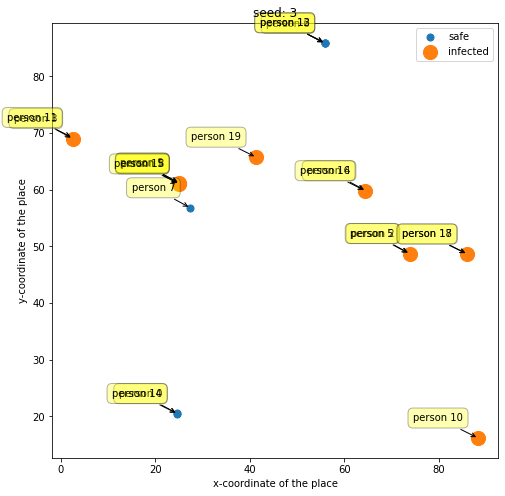

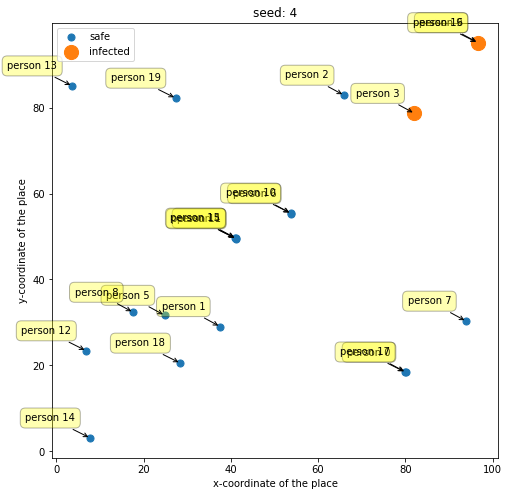

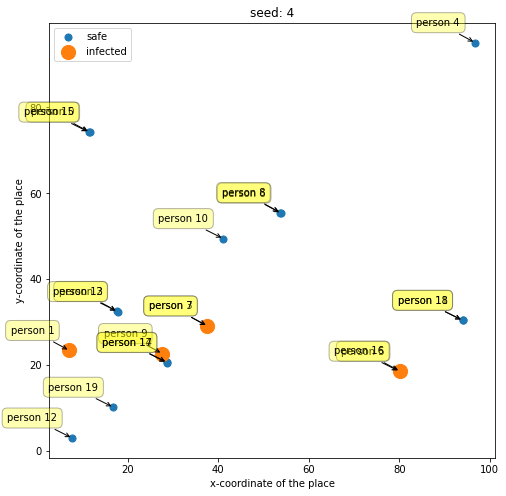

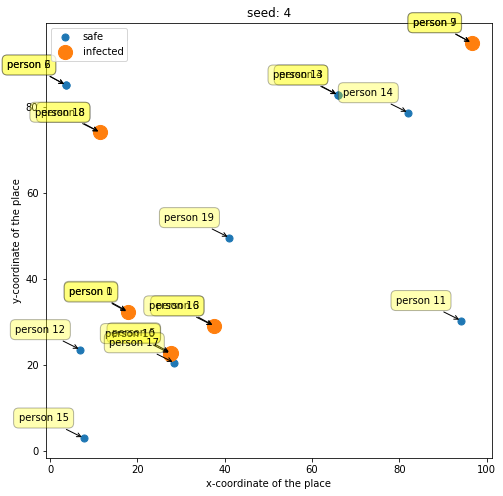

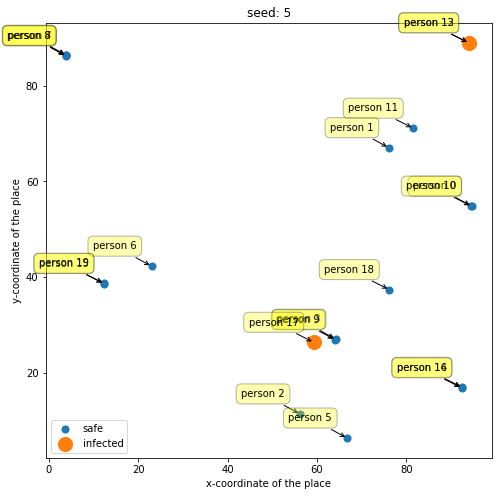

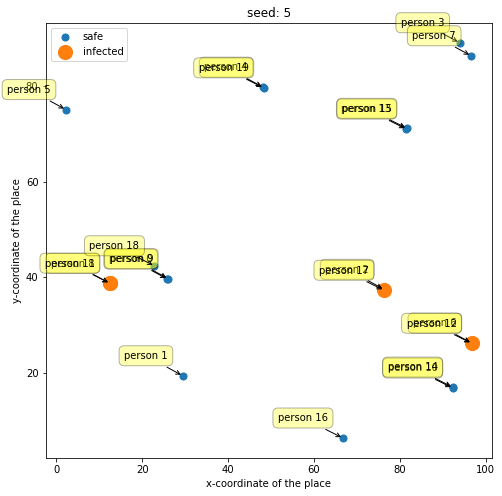

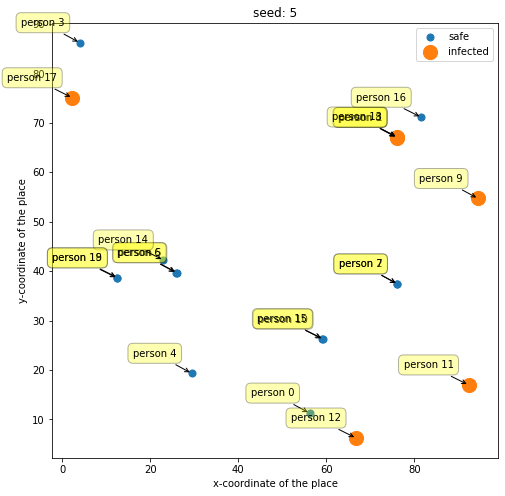

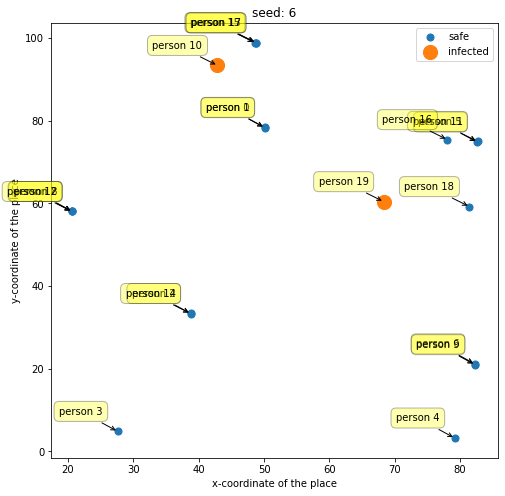

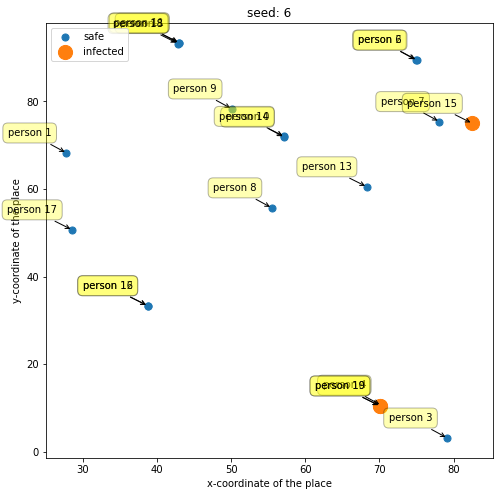

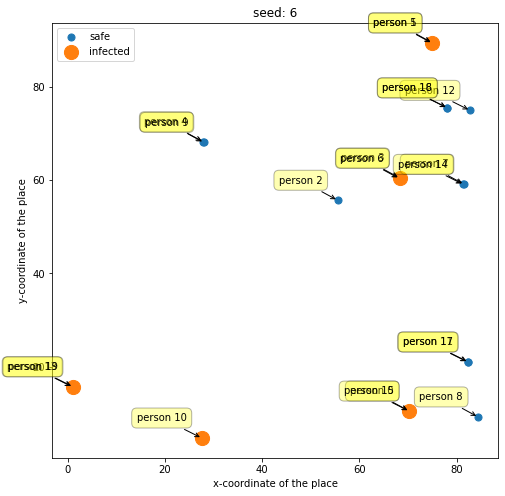

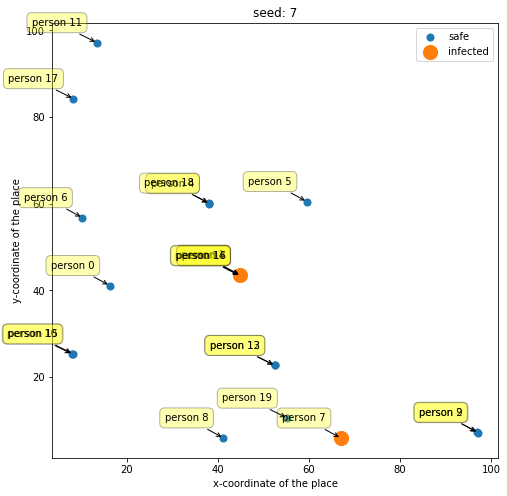

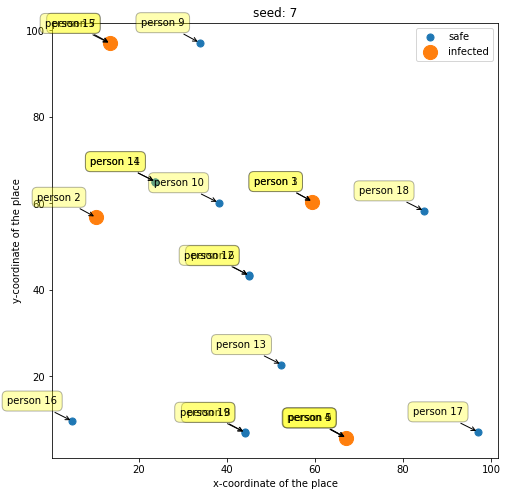

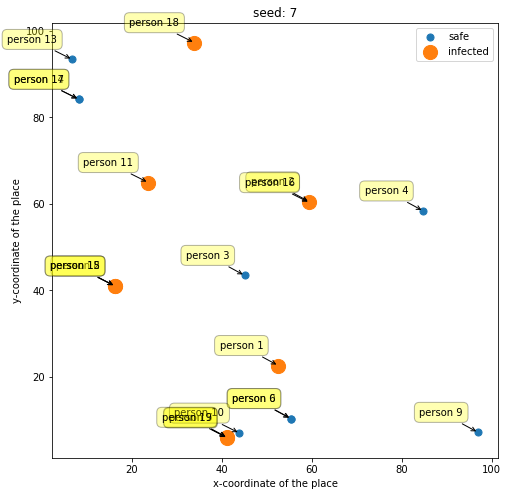

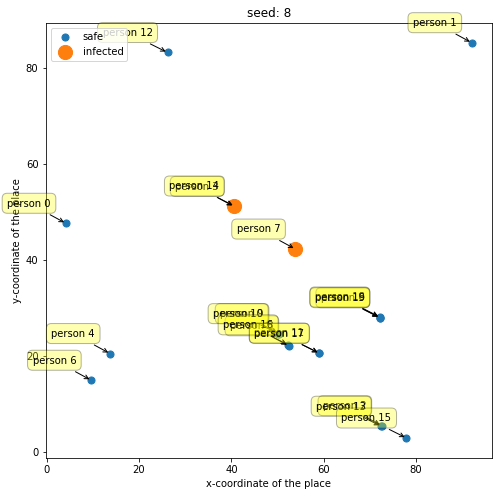

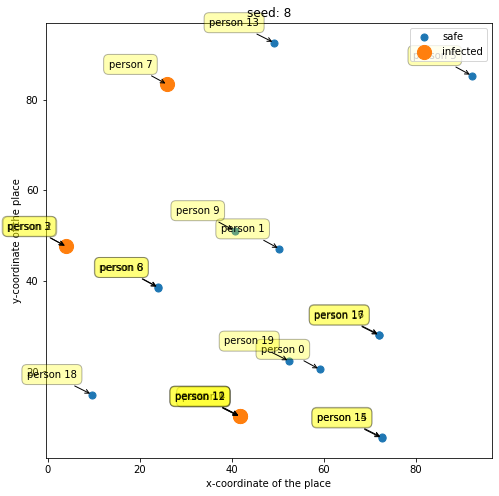

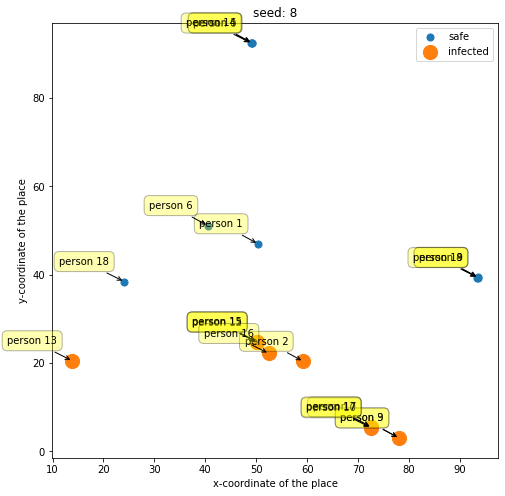

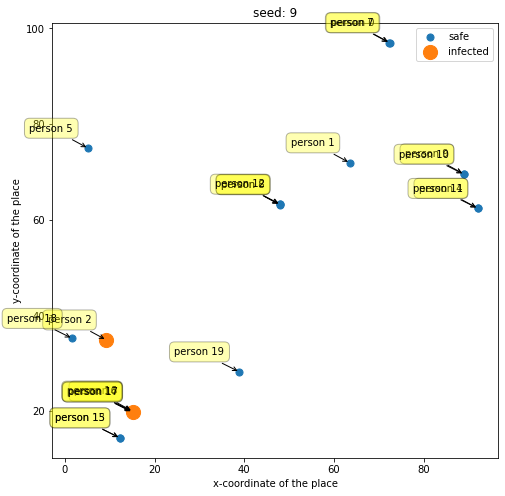

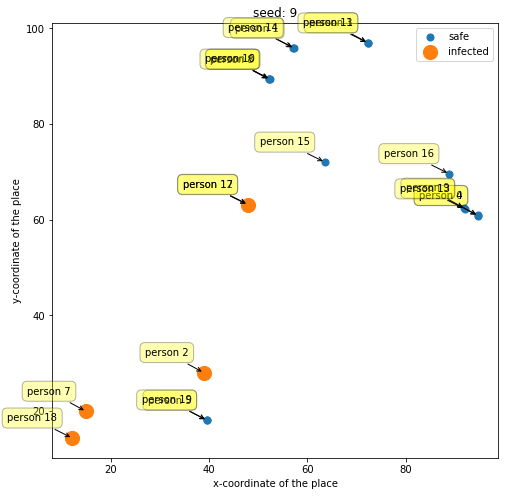

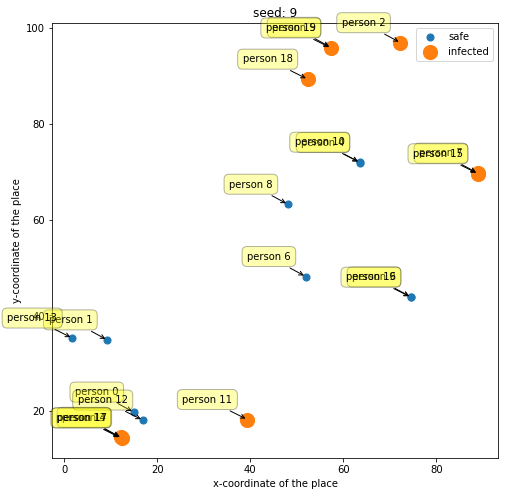

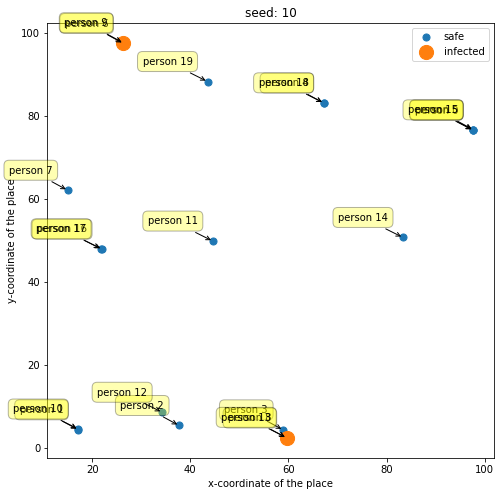

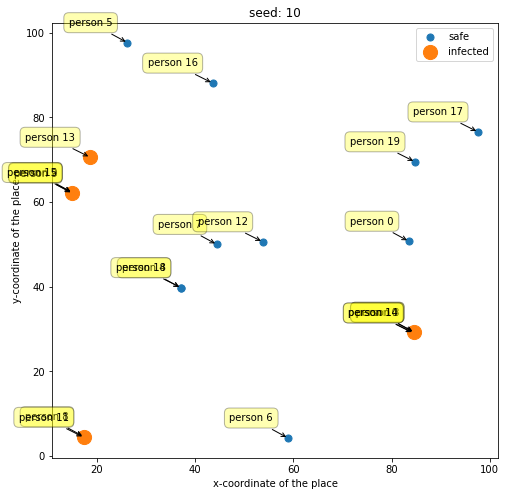

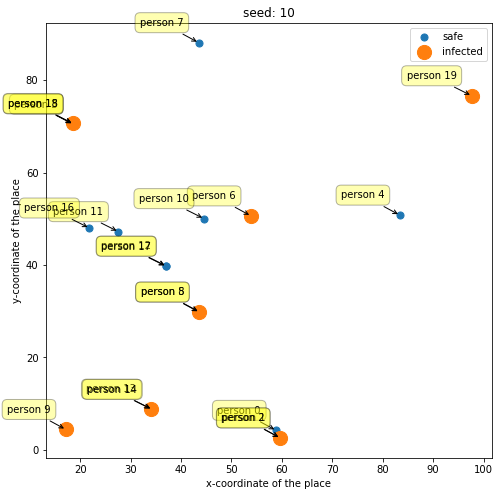

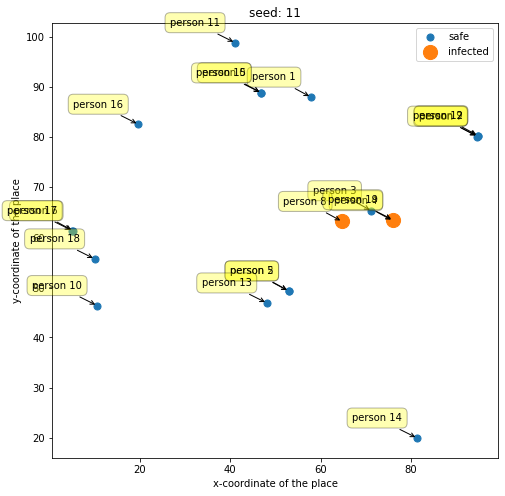

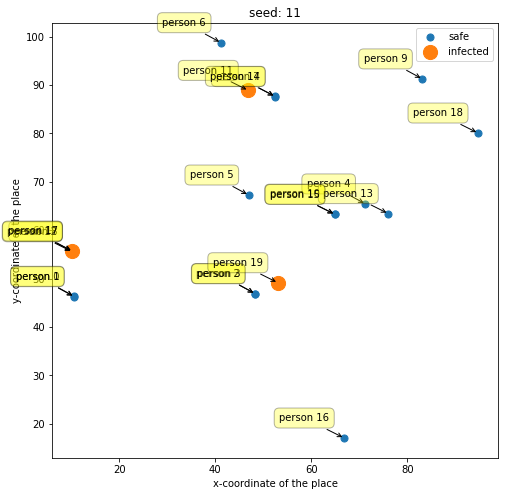

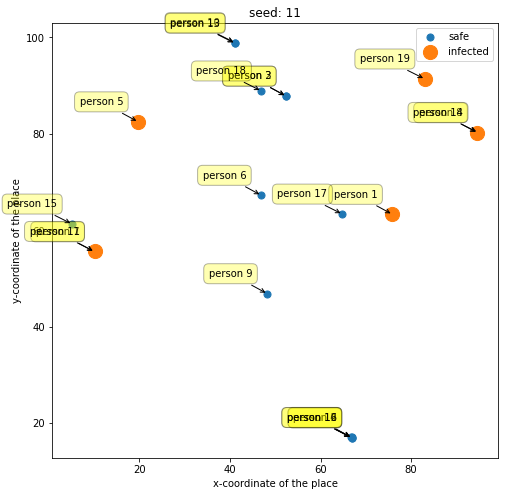

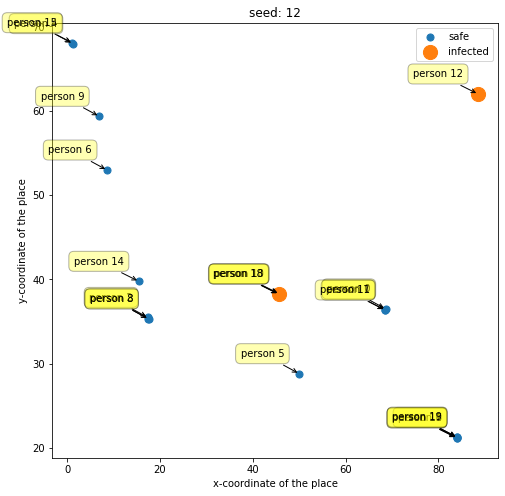

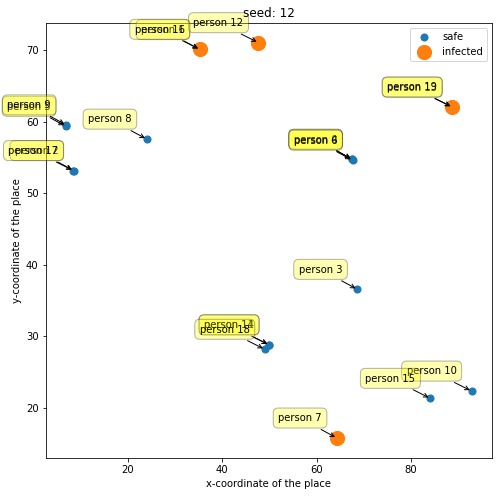

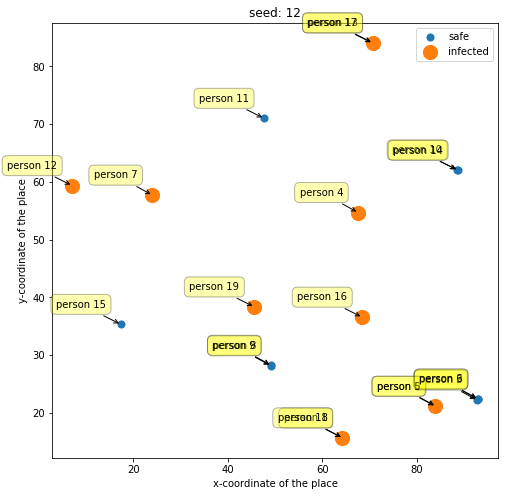

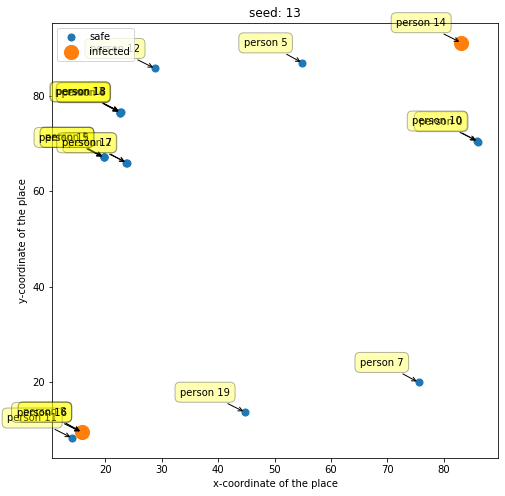

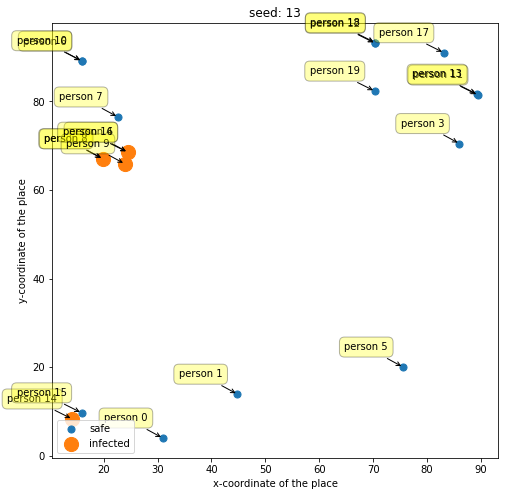

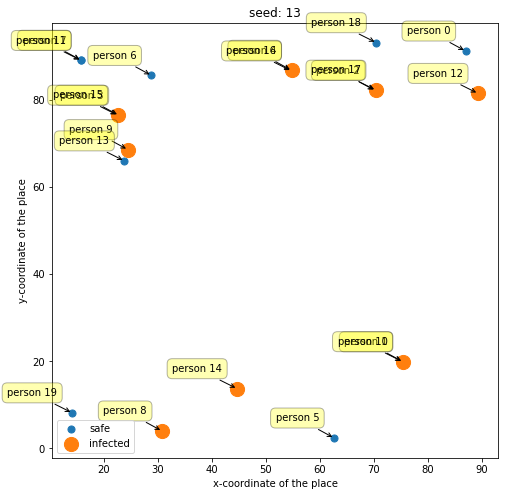

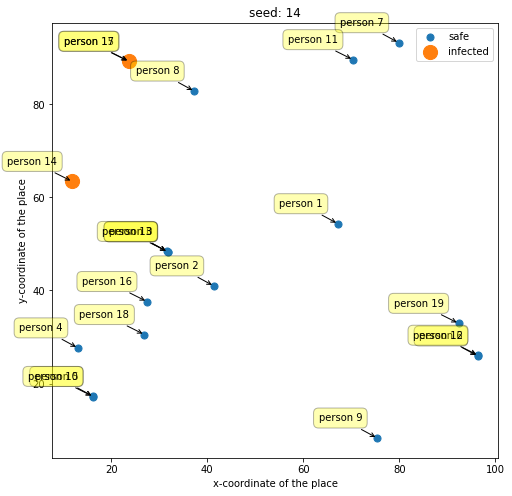

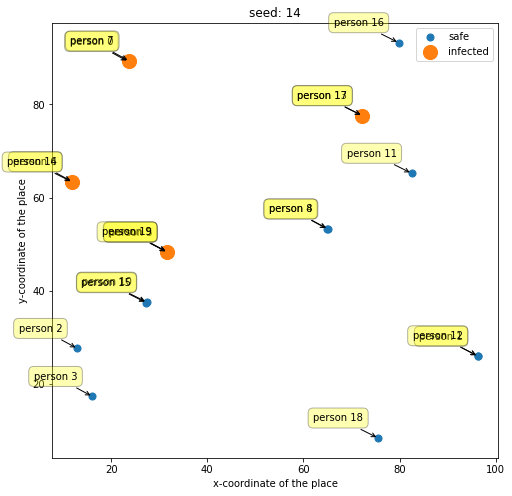

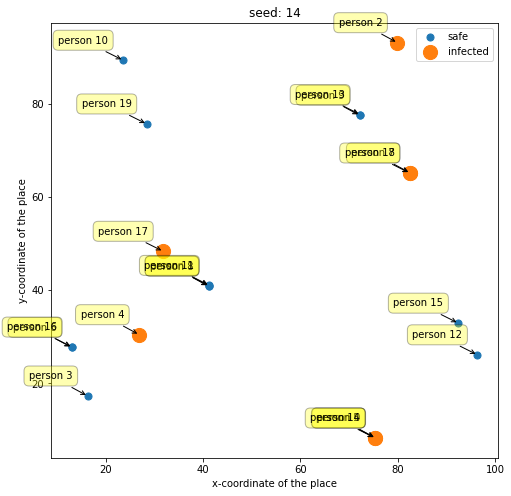

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


infected_avg = [] 
infected_std = []
seed_list = []


for s in range(15): # Simulation carried out for 15 different seed values
    random.seed(s)
    
    def rand_initialize(num_people, class_size):
        
        '''
        The function randomnly initializes positions for a number of people in an area of fixed square dimensions.
        A dictionary of the person's id (a natural number) with the corresponding initial position is returned.
        '''
        
        sp={}
        for i in range(num_people):
            sp[i] = []
            sp[i].append(np.array([random.sample(list(np.linspace(1, class_size, 2000)), 1)[0], random.sample(list(np.linspace(1, class_size, 2000)), 1)[0]]))
        return sp


    def random_move(position, a):
        
        '''
        The function takes in 2 inputs - the initial position of the person, and the average step he/she takes while moving, 
        in a single time-step.
        It returns the new positions of the same person.
        '''
        
        x, y = position
        x = x + a*np.cos(2*np.pi*random.sample(list(np.linspace(0, 1, 200)), 1)[0])
        y = y + a*np.sin(2*np.pi*random.sample(list(np.linspace(0, 1, 200)), 1)[0])
        return x, y


    def assign_infection(l, prob_infected):
        
        '''
        The function takes in the probability of getting infected and a list of ids (or names) of people as inputs 
        and returns a dictionary of random people assigned with infections according to a uniform probability passed.
        '''
        
        num_infected = int(prob_infected*len(l))
        form = {}
        infected = random.sample(l, k=num_infected)
        safe = []
        for i in range(len(l)):
            if l[i] not in infected:
                safe.append(l[i])
        for i in range(len(l)):
            form[l[i]] = []
        for i in infected:
            form[i].append('infected')
        for j in safe:
            form[j].append('safe')
        return form
    
    def infected_list(infected_dict):
        
        '''
        The function takes in a dictionary of people infected and returns a list of their corresponding ids/names.
        '''
        
        inf = []
        for k in infected_dict:
            if infected_dict[k][0] == 'infected':
                inf.append(int(k))
        return inf

    def prob(k, po, D):
        
        '''
        The function that captures the infection spreading in the community, depending on their relative positions.
        po: probability of getting infected at least possible distance (very close to 1)
        k: rate of decay of the probability with distance (=1/dmax)
        D: the distance between 2 people 
        '''
        
        return po*np.e**(-k*D)


    class_size=[100, 100] # units: m^2
    num_people=20
    people = rand_initialize(num_people, class_size[0])
    names = [] # list of ids/names of people in the setting
    for i in people:
        names.append(i)


    deltat = 1 # units: min
    T = 3 # units: min
    positions = {} # a dictionary to capture the coordinates of each person at different time_steps
    status = {} # a dictionary that captures the initial status (infected/safe) of a person
    d = {} # a dictionary that holds the distance between the infected person and the other people in the room (redundancy is permitted)
    dmax = 2 # (assumed value) units: m
    k = 1/dmax # decay rate
    infec = [] # a list that captures all the infected people in different time steps of the same seed
    po = 1 # max prob
    new_status = {} # the dictionary that captures the updated status (infected/safe) after each time_step
    infected = [] # a list to capture the proportion of people infected during each timestep
    time = []
    probability_of_getting_infected = {} # dictionary to capture the probabilities of infection for each person after different time_steps according to the probability law assumed
    a = 0.1 # units: m
    proba_infection=0.05 # initial probability of infection in the room/area
    probability_threshold = 0.2 # (assumed value)  the minimum threshold above which the person is marked to be infected

    infected_dict = assign_infection(names, proba_infection)
    inf = infected_list(infected_dict)
    for t in range(0, T, deltat):
        positions[str(t+1)] = []
        status[str(t+1)] = []
    for t in range(0, T, deltat):
        for _ in range(len(people)): # move each person randomnly
            for j in random.sample(list(people), 1):
                x, y = random_move(people[j][0], a) # random move
                positions[str(t+1)].append([x, y])
            # move with some proba - assumed to be uniform
                status[str(t+1)].append(infected_dict[j])
        for i in inf:
            for p in positions:
                d['person_id: ' + str(i) + ', ' + 'time_interval: ' + p] = []
                for j in positions[p]:
                      d['person_id: ' + str(i) + ', ' + 'time_interval: ' + p].append(round(np.sqrt((j[0] - positions[p][i-1][0])**2 + (j[1] - positions[p][i-1][1])**2), 3))
        for i in d:
            probability_of_getting_infected[i] = []
            for j in d[i]:
                probability_of_getting_infected[i].append(prob(k, po, j))

        list_status = [v for _, v in probability_of_getting_infected.items()]
        for i in range(int(len(list_status)/len(inf))):
            new_status[str(i+1)] = []
            for j in range(len(list_status[i])):
                try:
                    if list_status[i][j] > probability_threshold and list_status[i+T][j] > probability_threshold:
                        new_status[str(i+1)].append('infected')
                    else:
                        new_status[str(i+1)].append('safe')
                except:
                    pass
        status = new_status
        infected_dict = assign_infection(names, len(np.unique(inf))/len(names))
        inf = np.unique(inf + infected_list(infected_dict)).tolist()
        infected.append(len(inf)/len(people))
        time.append(t+1)
        infec.append(inf)
    
    
    infected_avg.append(np.mean(inf)) # collecting the average infection numbers per seed
    infected_std.append(np.std(inf)) # std error in the average infection numbers per seed
    seed_list.append(s) # seed values used to simulate
    
    
    # The plots generated below are for each time_step under different seeds
    
    names = [] # arbitrary list to keep track of people in the below generated plots    
    for i in range(len(people)):
        names.append('person' + ' ' + str(i))
    
    for k in range(3):
        infected_pos = [] # coordinates of infected people
        for i in infec[k]:
            infected_pos.append(positions[str(k+1)][i])
        safe_pos = [ele for ele in positions[str(k+1)] if ele not in infected_pos] # coordinates of safe people
        x_inf = []
        y_inf = []
        for i in infected_pos:
            x_inf.append(i[0])
            y_inf.append(i[1])
        x_safe = []
        y_safe = []
        for i in safe_pos:
            x_safe.append(i[0])
            y_safe.append(i[1])
        plt.figure(figsize=(8,8))
        plt.scatter(x_safe, y_safe, s = 50, label='safe')
        plt.scatter(x_inf, y_inf, s = 200, label='infected')
        plt.xlabel('x-coordinate of the place')
        plt.ylabel('y-coordinate of the place')
        plt.legend(loc='best')
        for idx, pos in enumerate(positions[str(k+1)]):
            plt.annotate(names[idx], 
                         xy = tuple(pos),
                         xytext = (-15, 15), ha = 'right', va = 'bottom',
                         textcoords = 'offset points',
                         bbox = dict(boxstyle = 'round,pad=0.5', fc = 'yellow', alpha = 0.3),
                         arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0')
                        )
            plt.title('seed: ' + str(s))

Text(0.5, 1.0, 'Overall behavior of the infection with standard errors')

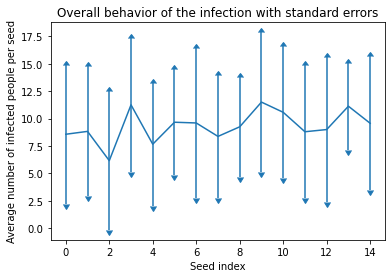

In [2]:
# Plot of average infection numbers per seed with standard errors marked with the arrows

plt.errorbar(seed_list, infected_avg, yerr = infected_std, uplims=10, lolims=10)
plt.ylabel('Average number of infected people per seed')
plt.xlabel('Seed index')
plt.title('Overall behavior of the infection with standard errors')

In [3]:
# A secondary function to give a rough estimate of number students to be accomodated in a stationary sitting (a classroom) following some norms

# Can we accomodate these many people in a place, assuming them to be almost stationary throughout.

def can_accomodate(place_size, dist_norm, air_space_class=[2, 3], air_space_people=1):
    '''
    place_size (list): [length, breadth]
    dist_norm: min_distance between people to be followed
    air_space_people: comfort+size..etc.
    air_space_class (list): class_room size not used [length, breadth]
    '''        
    return int(((place_size[0]-2*air_space_class[0])*(place_size[1]-2*air_space_class[1]))/((air_space_people/2 + dist_norm)**2))
can_accomodate(place_size=[30, 30], dist_norm=2)

99